# Index Creation, Charting, Simple Statistical Analysis and Connectedness

## Part 1: Loading the required libraries

In [2]:
%load_ext rpy2.ipython

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # For better date formatting
import openpyxl
import numpy as np

from statsmodels.tsa.stattools import adfuller, kpss



Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


In [3]:
%%R

# This entire cell is now R code!
print("Hello from the R world, inside my Python notebook!")

# Let's load the library you installed to prove it works
library(ConnectednessApproach)

# Let's check our R version info
sessionInfo()

[1] "Hello from the R world, inside my Python notebook!"
R version 4.5.1 (2025-06-13 ucrt)
Platform: x86_64-w64-mingw32/x64
Running under: Windows 11 x64 (build 26100)

Matrix products: default
  LAPACK version 3.12.1

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

time zone: America/Mexico_City
tzcode source: internal

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] ConnectednessApproach_1.0.4

loaded via a namespace (and not attached):
 [1] rmgarch_1.4-2                shape_1.4.6.1               
 [3] xfun_0.53                    ks_1.15.1                   
 [5] lattice_0.22-7               numDeriv_2016.8-1.1         
 [7] quadprog_1.5-8               vctrs_0.6.5                 
 [9] parallel_4.5.1               s


Please cite as: 

 Gabauer, David (2022). ConnectednessApproach.
 R package version 1.0.0. https://CRAN.R-project.org/package=ConnectednessApproach 



## Part 2: Functions for loading in the prices from Refinitiv for each stock and to calculate our index.

### Function 2.A: Load and Prepare Refinitiv obtained company price data from each group.

In [4]:
def load_and_prepare_data(filepath, sheet_name):
    """
    Loads raw price data from a specific sheet in an Excel file.
    The expected format is repeating pairs of (Date, Price) columns for each company.
    """
    print(f"  - Reading sheet '{sheet_name}' from '{filepath}'...")
    try:
        df_raw = pd.read_excel(filepath, sheet_name=sheet_name, header=0)
    except FileNotFoundError:
        print(f"    ERROR: File not found at {filepath}")
        return pd.DataFrame()
    except ValueError:
        print(f"    ERROR: Sheet '{sheet_name}' not found in the file.")
        return pd.DataFrame()
        
    all_company_data = []

    for i in range(0, df_raw.shape[1], 2):
        date_col = df_raw.iloc[:, i]
        price_col = df_raw.iloc[:, i+1]
        company_name = price_col.name

        company_df = pd.DataFrame({'Date': date_col, 'Price': price_col}).copy()
        company_df.dropna(inplace=True)

        company_df['Date'] = pd.to_datetime(company_df['Date'], errors='coerce')
        company_df['Price'] = pd.to_numeric(company_df['Price'], errors='coerce')
        company_df.dropna(inplace=True)

        if not company_df.empty:
            company_df.set_index('Date', inplace=True)
            company_df.rename(columns={'Price': company_name}, inplace=True)
            all_company_data.append(company_df)

    if not all_company_data:
        print(f"    WARNING: No valid company data found in sheet '{sheet_name}'.")
        return pd.DataFrame()

    merged_df = pd.concat(all_company_data, axis=1, join='outer')
    merged_df.sort_index(inplace=True)
    return merged_df


### Function 2.B: Calculating the Equally Weighted Indexes

In [5]:
def calculate_equal_weighted_index(price_data_df, base_value=100):
    """
    Calculates an equal-weighted index. This is your original, robust function.
    """
    if price_data_df.empty:
        return pd.Series(dtype=float), pd.DataFrame(dtype=float), pd.DataFrame(dtype=float), pd.Series(dtype=int)

    filled_price_data = price_data_df.ffill()
    daily_returns = filled_price_data.pct_change()
    num_companies_active = filled_price_data.notna().sum(axis=1)
    index_daily_returns = daily_returns.mean(axis=1)

    first_valid_date = None
    if not num_companies_active[num_companies_active > 0].empty:
        first_valid_date = num_companies_active[num_companies_active > 0].index[0]
        index_daily_returns.loc[first_valid_date] = 0
    else:
        return pd.Series(dtype=float), daily_returns, filled_price_data, num_companies_active

    index_values = base_value * (1 + index_daily_returns).cumprod()
    index_values = index_values.reindex(filled_price_data.index)

    if first_valid_date:
        if not index_values.empty and index_values.index[0] < first_valid_date:
             index_values.loc[:pd.Timestamp(first_valid_date) - pd.Timedelta(days=1)] = float('nan')
        if first_valid_date in index_values.index:
            index_values.loc[first_valid_date] = base_value
    else:
        index_values[:] = float('nan')

    return index_values, daily_returns, filled_price_data, num_companies_active

### Function 2.C: Processing

In [6]:
def process_sheet_to_index(file_path, sheet_name_to_process):
    """
    A wrapper function that combines loading and calculation for one index group.
    """
    print(f"\n--- Processing: {sheet_name_to_process} ---")
    
    price_df = load_and_prepare_data(file_path, sheet_name_to_process)

    if not price_df.empty:
        # Call your original function and accept all four returned items
        # We use underscores '_' to indicate that we won't use the other returned values
        index_values, _, _, _ = calculate_equal_weighted_index(price_df)
        
        index_values.name = sheet_name_to_process
        print(f"  - Successfully calculated '{sheet_name_to_process}'.")
        return index_values
    else:
        return None

### Function 2.D: Plotting all the indexes in a single chart

In [7]:
def plot_multiple_indices(indices_df, color_map, title='Comparative Index Performance'):
    """Plots multiple index series using a predefined color map."""
    monthly_df = indices_df.resample('M').last()
    plt.figure(figsize=(14, 7))
    for column in monthly_df.columns:
        # Use the color from the map for this specific index
        color = color_map.get(column, 'black') # Default to black if not found
        plt.plot(monthly_df.index, monthly_df[column], marker='o', linestyle='-', label=column, color=color)
    plt.title(title, fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Index Value (Re-based to 100)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=max(1, len(monthly_df) // 12)))
    plt.gcf().autofmt_xdate()
    plt.show()

### Function 2.E: Plotting Individual Indexes

In [8]:
def plot_single_index(index_series, color, title='Index Performance', y_limits=None):
    """Plots a single index using a specific color."""
    monthly_series = index_series.resample('M').last().dropna()
    if monthly_series.empty:
        print(f"No monthly data to plot for '{title}'.")
        return
    plt.figure(figsize=(12, 6))
    # Pass the specific color to the plot command
    plt.plot(monthly_series.index, monthly_series.values, marker='o', linestyle='-', label=index_series.name, color=color)
    plt.title(title, fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Index Value')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    if y_limits:
        plt.ylim(y_limits)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=max(1, len(monthly_series) // 12)))
    plt.gcf().autofmt_xdate()
    plt.show()

## Part 3: Main Script

--- Step 1: Automatically detecting sheets in 'All Bank Data.xlsx' ---
Success! Found 3 sheets to process:
  - Traditionals
  - NeoBanks
  - Challengers

--- Processing: Traditionals ---
  - Reading sheet 'Traditionals' from 'All Bank Data.xlsx'...
  - Successfully calculated 'Traditionals'.

--- Processing: NeoBanks ---
  - Reading sheet 'NeoBanks' from 'All Bank Data.xlsx'...
  - Successfully calculated 'NeoBanks'.

--- Processing: Challengers ---
  - Reading sheet 'Challengers' from 'All Bank Data.xlsx'...
  - Successfully calculated 'Challengers'.

--- Aligning all indices to first common start date: 2017-01-02 ---
--- Truncating all data to end on or before: 2025-05-01 ---

--- Assigned consistent colors to each index for plotting ---

--- Aligned and Re-based Index Comparison (First & Last 5 rows) ---
            Traditionals    NeoBanks  Challengers
Date                                             
2017-01-02    100.000000  100.000000   100.000000
2017-01-03    101.024689  103.1

C:\Users\James\AppData\Local\Temp\ipykernel_19676\170446306.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(final_slice_df.columns))
C:\Users\James\AppData\Local\Temp\ipykernel_19676\611148105.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = indices_df.resample('M').last()


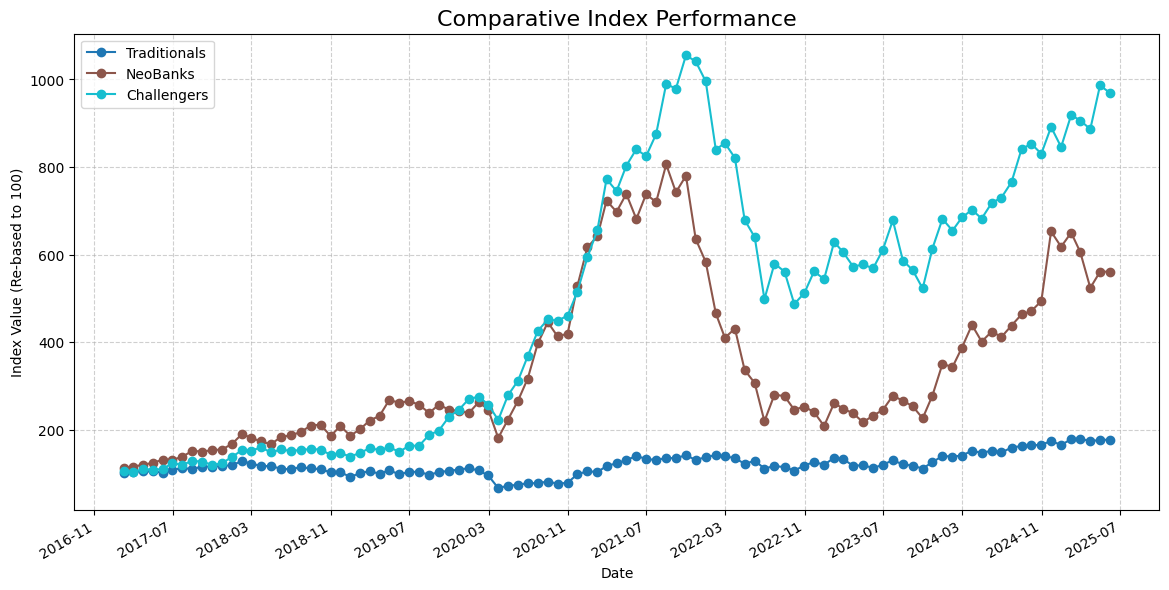


--- Generating individual plots from 2017-01-02 to 2025-05-01 ---
Standardizing individual plot Y-axis from 20.36 to 1166.29


C:\Users\James\AppData\Local\Temp\ipykernel_19676\540654191.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_series = index_series.resample('M').last().dropna()


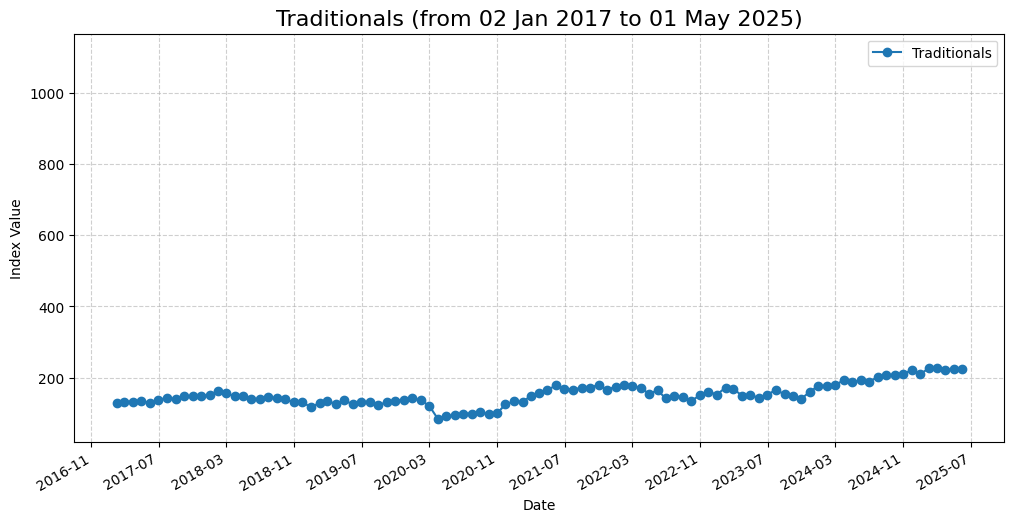

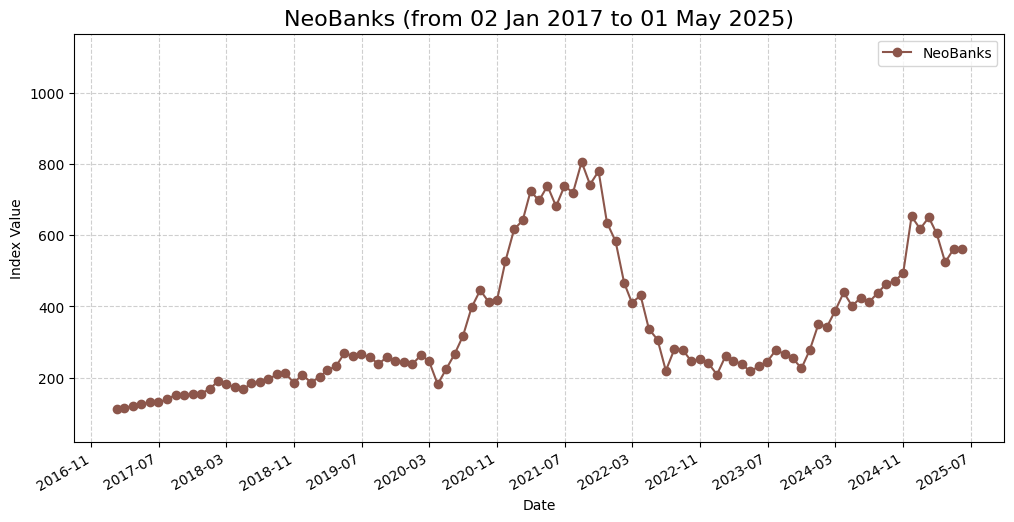

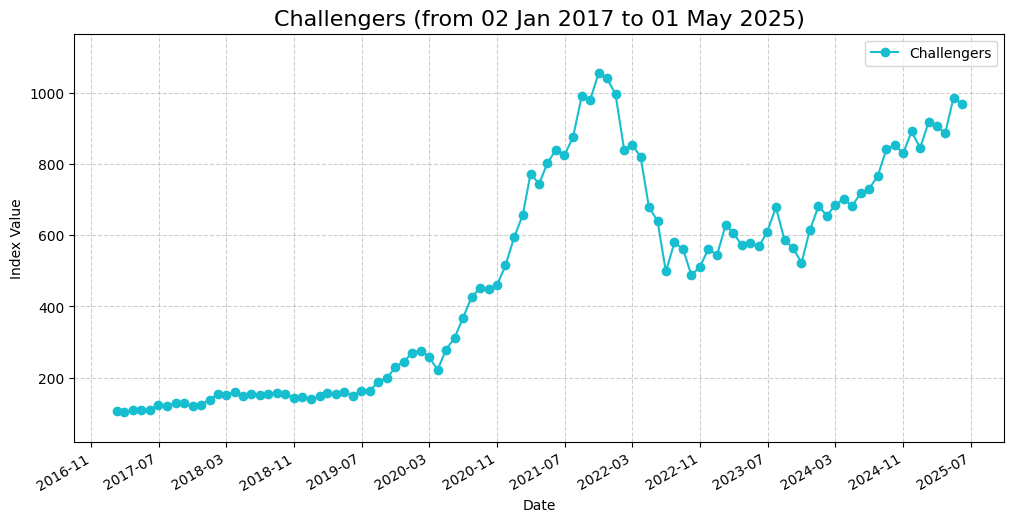

In [9]:
# 1. DEFINE YOUR PARAMETERS AND AUTOMATICALLY DETECT SHEETS
raw_data_file = "All Bank Data.xlsx"
hard_stop_date = pd.to_datetime('2025-05-01')

print(f"--- Step 1: Automatically detecting sheets in '{raw_data_file}' ---")
try:
    # Use pd.ExcelFile to inspect the workbook without loading all data
    xls = pd.ExcelFile(raw_data_file)
    sheets_to_process = xls.sheet_names
    print(f"Success! Found {len(sheets_to_process)} sheets to process:")
    for name in sheets_to_process:
        print(f"  - {name}")
except FileNotFoundError:
    print(f"FATAL ERROR: The file '{raw_data_file}' was not found. Script will now exit.")
    sys.exit() # Exits the script
except Exception as e:
    print(f"FATAL ERROR: An unexpected error occurred while reading the Excel file: {e}")
    sys.exit() # Exits the script

# 2. CALCULATE ALL INDICES FROM THE RAW DATA FILE
calculated_indices = []
for sheet in sheets_to_process:
    index_result = process_sheet_to_index(raw_data_file, sheet)
    if index_result is not None and not index_result.dropna().empty:
        calculated_indices.append(index_result)

# 3. PROCEED ONLY IF INDICES WERE SUCCESSFULLY CALCULATED
if len(calculated_indices) < 2:
    print("\n--- ERROR: Fewer than two indices were successfully calculated. Cannot proceed. ---")
else:
    all_indices_df = pd.concat(calculated_indices, axis=1)
    # --- NEW, CRITICAL LINE TO FIX THE MISSING VALUE ISSUE ---
    # After concatenating, some dates might have NaN if one index had data and another didn't (e.g., holidays).
    # We forward-fill one more time on the final combined DataFrame to clean these up.
    all_indices_df.ffill(inplace=True)

    # --- Part 3.A: Align Data and Generate Plots ---
    first_common_date = all_indices_df.dropna().index[0]
    print(f"\n--- Aligning all indices to first common start date: {first_common_date.date()} ---")
    print(f"--- Truncating all data to end on or before: {hard_stop_date.date()} ---")
    
    final_slice_df = all_indices_df.loc[first_common_date:hard_stop_date].copy()
    comparison_df = (final_slice_df / final_slice_df.iloc[0]) * 100
    
    # --- NEW: Create a consistent color map for all plots ---
    colors = plt.cm.get_cmap('tab10', len(final_slice_df.columns))
    color_map = {col: colors(i) for i, col in enumerate(final_slice_df.columns)}
    print("\n--- Assigned consistent colors to each index for plotting ---")
    
    # --- Generate Comparative Chart with new color map ---
    print("\n--- Aligned and Re-based Index Comparison (First & Last 5 rows) ---")
    print(comparison_df.head())
    print(comparison_df.tail())
    plot_multiple_indices(comparison_df, color_map=color_map, title='Comparative Index Performance')

    # --- Generate Individual Charts with new color map and standardized Y-Axis ---
    print(f"\n--- Generating individual plots from {first_common_date.date()} to {hard_stop_date.date()} ---")
    global_min, global_max = final_slice_df.min().min(), final_slice_df.max().max()
    padding = (global_max - global_min) * 0.05
    y_axis_limits = (global_min - padding, global_max + padding)
    print(f"Standardizing individual plot Y-axis from {y_axis_limits[0]:.2f} to {y_axis_limits[1]:.2f}")

    for index_name in final_slice_df.columns:
        plot_single_index(
            index_series=final_slice_df[index_name], 
            color=color_map[index_name], # Pass the specific color
            title=f"{index_name} (from {first_common_date.strftime('%d %b %Y')} to {hard_stop_date.strftime('%d %b %Y')})",
            y_limits=y_axis_limits
        )

## Saving the equal/aligned indexes to excel.

In [10]:
# 1. DEFINE THE OUTPUT FILENAME
output_file_name = 'calculated_indices_EQUAL.xlsx'

# 2. CHECK IF THE RE-BASED DATA EXISTS
# We use 'comparison_df' which contains the data re-based to 100.
if 'comparison_df' in locals() and not comparison_df.empty:
    print(f"\n--- Saving re-based index data (starts at 100) to: {output_file_name} ---")
    
    try:
        # Use pd.ExcelWriter to save multiple sheets to one file.
        with pd.ExcelWriter(output_file_name, engine='openpyxl') as writer:
            
            # Loop through each column (each index) in the comparison DataFrame.
            for index_name in comparison_df.columns:
                
                # Select the data for the current index.
                single_index_df = comparison_df[[index_name]]
                
                # Write this single-column DataFrame to a new sheet.
                single_index_df.to_excel(writer, sheet_name=index_name, index=True)
                
                print(f"  - Saved '{index_name}' to its own sheet.")

        print(f"\nSuccessfully created '{output_file_name}'. Each index starts at 100.")

    except Exception as e:
        print(f"\nERROR: Could not save the Excel file. Reason: {e}")
        
else:
    print("\n--- No final re-based data available to save. Skipping file export. ---")


--- Saving re-based index data (starts at 100) to: calculated_indices_EQUAL.xlsx ---
  - Saved 'Traditionals' to its own sheet.
  - Saved 'NeoBanks' to its own sheet.
  - Saved 'Challengers' to its own sheet.

Successfully created 'calculated_indices_EQUAL.xlsx'. Each index starts at 100.


# Part 4: Functions for Stationary Testing

## Function 4.A: Running ADF and KPSS on the 3 indexes

In [11]:
def run_stationarity_tests(series, series_name):
    """
    Runs and interprets the Augmented Dickey-Fuller and KPSS tests on a time series.
    This is your original, detailed function.
    """
    print(f"\n--- Stationarity Tests for {series_name} ---")
    series_cleaned = series.dropna()

    # --- Augmented Dickey-Fuller Test ---
    print("\n1. Augmented Dickey-Fuller Test (ADF):")
    adf_result = adfuller(series_cleaned)
    p_value_adf = adf_result[1]
    print(f"   ADF Statistic: {adf_result[0]:.4f}")
    print(f"   p-value: {p_value_adf:.4f}")
    print("   Critical Values:")
    for key, value in adf_result[4].items():
        print(f'      {key}: {value:.4f}')
    if p_value_adf <= 0.05:
        print("\n   Conclusion: Strong evidence against the null hypothesis (p <= 0.05).")
        print("   Reject the null hypothesis. The series is likely stationary.")
    else:
        print("\n   Conclusion: Weak evidence against the null hypothesis (p > 0.05).")
        print("   Fail to reject the null hypothesis. The series is likely non-stationary.")

    # --- KPSS Test ---
    print("\n2. Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS):")
    kpss_result = kpss(series_cleaned, regression='ct')
    p_value_kpss = kpss_result[1]
    print(f"   KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"   p-value: {p_value_kpss:.4f}")
    print("   Critical Values:")
    for key, value in kpss_result[3].items():
        print(f'      {key}: {value:.4f}')
    if p_value_kpss <= 0.05:
        print("\n   Conclusion: Strong evidence against the null hypothesis (p <= 0.05).")
        print("   Reject the null hypothesis. The series is likely non-stationary.")
    else:
        print("\n   Conclusion: Weak evidence against the null hypothesis (p > 0.05).")
        print("   Fail to reject the null hypothesis. The series is likely trend-stationary.")

### Function 5.B: Testing for stationarity on Index RETURNS (YOUR ORIGINAL FUNCTION)
def run_stationarity_tests_on_transformed_data(series, series_name):
    """
    Runs ADF and KPSS tests specifically for transformed (differenced) data.
    This is your original, detailed function for returns.
    """
    print(f"\n--- Stationarity Tests for: {series_name} ---")
    
    # --- Augmented Dickey-Fuller Test ---
    print("\n1. Augmented Dickey-Fuller Test (ADF):")
    adf_result = adfuller(series)
    p_value_adf = adf_result[1]
    print(f"   p-value: {p_value_adf:.4f}")
    if p_value_adf <= 0.05:
        print("   Conclusion: REJECT the null hypothesis. The series is likely STATIONARY.")
    else:
        print("   Conclusion: FAIL to reject the null hypothesis. The series is likely NON-STATIONARY.")

    # --- KPSS Test ---
    print("\n2. Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS):")
    kpss_result = kpss(series, regression='c')
    p_value_kpss = kpss_result[1]
    print(f"   p-value: {p_value_kpss:.4f}")
    if p_value_kpss <= 0.05:
        print("   Conclusion: REJECT the null hypothesis. The series is likely NON-STATIONARY.")
    else:
        print("   Conclusion: FAIL to reject the null hypothesis. The series is likely STATIONARY.")


# Part 5: Main Script for ADF and KPSS tests

In [12]:
# This automated loop will run the tests on every index calculated in Part 3.
if 'final_slice_df' in locals() and not final_slice_df.empty:
    
    # Loop through each column (each index) in our final DataFrame.
    for index_name in final_slice_df.columns:
        print(f"\n\n{'='*70}")
        print(f"PERFORMING STATIONARITY ANALYSIS FOR: {index_name}")
        print(f"{'='*70}")

        # --- Step 1: Test the original series (Levels) ---
        series_levels = final_slice_df[index_name]
        run_stationarity_tests(series_levels, f"{index_name} (Levels)")

        # --- Step 2: Test the transformed series (Returns) ---
        print("\n--- Applying First-Difference Transformation ---")
        series_returns = series_levels.diff().dropna()
        run_stationarity_tests_on_transformed_data(series_returns, f"{index_name} (Returns)")
else:
    print("\n--- Could not find calculated index data ('final_slice_df'). Skipping Stationarity Tests. ---")



PERFORMING STATIONARITY ANALYSIS FOR: Traditionals

--- Stationarity Tests for Traditionals (Levels) ---

1. Augmented Dickey-Fuller Test (ADF):
   ADF Statistic: -1.1346
   p-value: 0.7011
   Critical Values:
      1%: -3.4334
      5%: -2.8629
      10%: -2.5675

   Conclusion: Weak evidence against the null hypothesis (p > 0.05).
   Fail to reject the null hypothesis. The series is likely non-stationary.

2. Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS):
   KPSS Statistic: 0.7314
   p-value: 0.0100
   Critical Values:
      10%: 0.1190
      5%: 0.1460
      2.5%: 0.1760
      1%: 0.2160

   Conclusion: Strong evidence against the null hypothesis (p <= 0.05).
   Reject the null hypothesis. The series is likely non-stationary.

--- Applying First-Difference Transformation ---

--- Stationarity Tests for: Traditionals (Returns) ---

1. Augmented Dickey-Fuller Test (ADF):
   p-value: 0.0000
   Conclusion: REJECT the null hypothesis. The series is likely STATIONARY.

2. Kwiatkowski-Ph

C:\Users\James\AppData\Local\Temp\ipykernel_19676\2362815342.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series_cleaned, regression='ct')
C:\Users\James\AppData\Local\Temp\ipykernel_19676\2362815342.py:61: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c')
C:\Users\James\AppData\Local\Temp\ipykernel_19676\2362815342.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series_cleaned, regression='ct')
C:\Users\James\AppData\Local\Temp\ipykernel_19676\2362815342.py:61: InterpolationWarning: The test statistic is outside of the range of p-valu

# Part 6: Descriptive Statistics

### This section calculates and displays a detailed statistical summary for each of the final, time-aligned indices (the 'levels' data from Part 3).

In [13]:
if 'final_slice_df' in locals() and not final_slice_df.empty:
    print(f"\n\n{'='*70}")
    print("CALCULATING DESCRIPTIVE STATISTICS")
    print(f"{'='*70}")
    
    try:
        # 1. The .describe() method calculates the most common stats
        summary_df = final_slice_df.describe()

        # 2. Calculate Skewness and Kurtosis separately
        skewness = final_slice_df.skew()
        kurtosis = final_slice_df.kurtosis()

        # 3. Add them as new rows to our summary DataFrame
        summary_df.loc['Skewness'] = skewness
        summary_df.loc['Kurtosis'] = kurtosis

        # 4. Display the final, formatted table
        print("\n--- Statistical Summary of Aligned Index Levels ---")
        
        # Optional: Set a display format for cleaner output
        pd.options.display.float_format = '{:,.4f}'.format
        
        print(summary_df)

    except Exception as e:
        print(f"\nAn error occurred while calculating statistics: {e}")

else:
    print("\n--- Could not find calculated index data ('final_slice_df'). Skipping Descriptive Statistics. ---")



CALCULATING DESCRIPTIVE STATISTICS

--- Statistical Summary of Aligned Index Levels ---
          Traditionals   NeoBanks  Challengers
count       2,159.0000 2,159.0000   2,159.0000
mean          152.6635   341.7846     480.5196
std            30.0546   187.7011     295.9075
min            72.4485   100.0000      96.1423
25%           133.7288   205.4675     156.2087
50%           148.2370   260.4697     532.4504
75%           170.7494   439.5708     723.4721
max           233.3720   846.1734   1,114.2027
Skewness        0.3512     0.9855       0.1573
Kurtosis        0.2303    -0.1455      -1.3519


# Part 7: Connectedness Analysis

In [14]:


print(f"\n\n{'='*70}")
print("PREPARING DATA FOR CONNECTEDNESS ANALYSIS")
print(f"{'='*70}")

if 'final_slice_df' in locals() and not final_slice_df.empty:
    # 1. Calculate daily percentage returns.
    # The .pct_change() method is perfect for this.
    returns_df = final_slice_df.pct_change()

    # 2. Drop the first row, which will be NaN after calculating returns.
    returns_df.dropna(inplace=True)

    # 3. Multiply by 100 to express returns as percentages (optional but common practice).
    returns_df = returns_df * 100

    print("\n--- Daily Returns Data Prepared for R (First 5 rows) ---")
    print(returns_df.head())

else:
    print("\n--- Could not find 'final_slice_df'. Skipping Connectedness Analysis. ---")
    # We will create an empty dataframe so the next cells don't error out
    returns_df = pd.DataFrame()



PREPARING DATA FOR CONNECTEDNESS ANALYSIS

--- Daily Returns Data Prepared for R (First 5 rows) ---
            Traditionals  NeoBanks  Challengers
Date                                           
2017-01-03        1.0247    3.1254       0.3080
2017-01-04        1.2603    2.7531       0.3522
2017-01-05       -0.0865    1.0332       0.7906
2017-01-06        0.1468    0.4642      -0.7026
2017-01-09       -0.5631    0.0415      -0.8442


## Step 2: Static Connectedness Analysis
This analysis gives us a single table that represents the average spillover effects over your entire sample period. It's a great starting point.

In [15]:
%%R -i returns_df

# Check if the input dataframe is not empty
if (nrow(returns_df) > 0) {
    # Load the necessary R libraries
    library(ConnectednessApproach)
    library(zoo)

    # Convert the pandas DataFrame to a zoo object, which the library requires
    # The date index is automatically recognized.
    data_zoo <- zoo(returns_df, order.by = as.Date(rownames(returns_df)))

    # --- Run the Static Connectedness Analysis ---
    # This calculates the average connectedness over the entire period.
    # nlag = 2: We use 2 lags in our model (a common starting point).
    # nfore = 10: We forecast 10 days ahead to see how shocks propagate.
    # window.size = NULL: This specifically tells the function to do a static (non-rolling) analysis.
    dca_static <- ConnectednessApproach(data_zoo,
                                      nlag = 2,
                                      nfore = 10,
                                      window.size = NULL,
                                      model = "VAR") # Using a standard Vector Autoregression model

    # Print the resulting connectedness table
    print("--- Static Connectedness Table (Average over entire period) ---")
    print(dca_static$TABLE)
} else {
    print("Input data is empty. Skipping static analysis.")
}

[1] "--- Static Connectedness Table (Average over entire period) ---"
             Traditionals NeoBanks Challengers FROM         
Traditionals "58.78"      "19.36"  "21.86"     "41.22"      
NeoBanks     "19.09"      "57.22"  "23.69"     "42.78"      
Challengers  "20.92"      "24.43"  "54.65"     "45.35"      
TO           " 40.01"     " 43.79" " 45.55"    "129.36"     
Inc.Own      " 98.79"     "101.01" "100.20"    "cTCI/TCI"   
NET          "-1.21"      " 1.01"  " 0.20"     "64.68/43.12"
NPT          "0.00"       "2.00"   "1.00"      ""           



Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Estimating model
Computing connectedness measures
The (generalized) VAR connectedness approach is implemented according to:
 Diebold, F. X., & Yilmaz, K. (2012). Better to give than to receive: Predictive directional measurement of volatility spillovers. International Journal of Forecasting.


## Step 3: Dynamic Connectedness Analysis
This is the main event. We'll use a rolling window to see how these spillovers evolve over time. This will allow us to create the insightful plots.


"To capture the time-varying nature of the spillover effects, this study employs the rolling-window VAR methodology as proposed by Diebold and Yilmaz (2012). A window size of 200 days was chosen to balance parameter stability with sensitivity to changes in market regimes. This approach provides a robust and well-established framework for analyzing dynamic connectedness."

In [16]:
%%R -i returns_df -o dca_dynamic_results

# Check if the input dataframe is not empty
if (nrow(returns_df) > 0) {
    library(ConnectednessApproach)
    library(zoo)

    data_zoo <- zoo(returns_df, order.by = as.Date(rownames(returns_df)))

    # --- Run the Dynamic (Rolling Window) Analysis ---
    # The only change is setting window.size.
    # window.size = 200: We use a 200-day rolling window, which is a common standard.
    # This means each calculation is based on the previous ~9 months of data.
    dca_dynamic_results <- ConnectednessApproach(data_zoo,
                                       nlag = 2,
                                       nfore = 10,
                                       window.size = 200, # This activates the dynamic analysis
                                       model = "VAR")

    # The object 'dca_dynamic' now contains the full history of connectedness over time.
    # We send it back to Python with '-o dca_dynamic_results' just in case,
    # but we will do the plotting in R.

    # Print the AVERAGE table from the dynamic results
    print("--- Average Dynamic Connectedness Table (Average of all rolling windows) ---")
    print(dca_dynamic_results$TABLE)
} else {
    print("Input data is empty. Skipping dynamic analysis.")
}

[1] "--- Average Dynamic Connectedness Table (Average of all rolling windows) ---"
             Traditionals NeoBanks Challengers FROM         
Traditionals "62.24"      "17.70"  "20.05"     "37.76"      
NeoBanks     "17.83"      "60.86"  "21.31"     "39.14"      
Challengers  "20.28"      "21.08"  "58.64"     "41.36"      
TO           " 38.11"     " 38.78" " 41.36"    "118.26"     
Inc.Own      "100.36"     " 99.64" "100.00"    "cTCI/TCI"   
NET          " 0.36"      "-0.36"  " 0.00"     "59.13/39.42"
NPT          "2.00"       "0.00"   "1.00"      ""           


Estimating model
Computing connectedness measures
The (generalized) VAR connectedness approach is implemented according to:
 Diebold, F. X., & Yilmaz, K. (2012). Better to give than to receive: Predictive directional measurement of volatility spillovers. International Journal of Forecasting.


## Step 4: Visualizing the Dynamic Results
Now we use the dca_dynamic object we just created in the R environment to generate the plots.

[1] "Plotting Total Connectedness Index (TCI)..."
[1] "Plotting Net Total Directional Connectedness (NET)..."
[1] "Plotting Net Pairwise Directional Connectedness (NPDC)..."


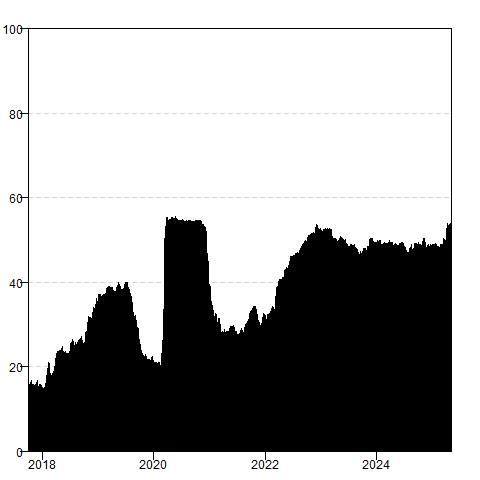

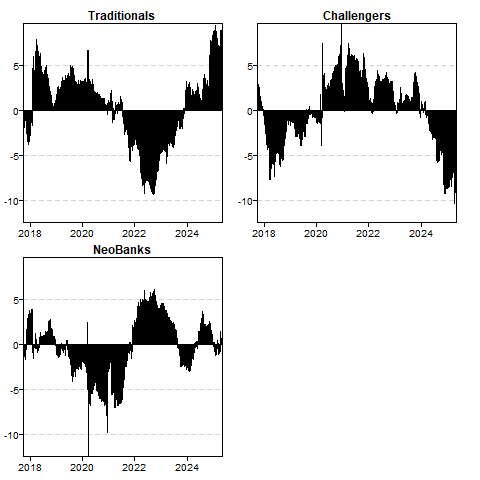

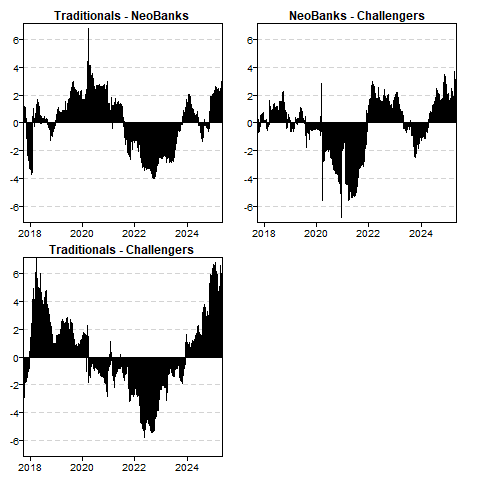

In [17]:
%%R

# This cell uses the 'dca_dynamic' object created in the cell above.
# We don't need to pass data in again.

if (exists("dca_dynamic_results")) {
    # --- Plot 1: Total Connectedness Index (TCI) ---
    # Shows the overall level of risk in the system over time.
    # Spikes indicate periods of high market stress and contagion.
    print("Plotting Total Connectedness Index (TCI)...")
    PlotTCI(dca_dynamic_results)

    # --- Plot 2: Net Total Directional Connectedness (NET) ---
    # THE MOST IMPORTANT PLOT. Shows who the net transmitters/receivers are over time.
    # When a line is > 0, that index is a net source of risk to the system.
    # When a line is < 0, that index is a net recipient of risk.
    print("Plotting Net Total Directional Connectedness (NET)...")
    PlotNET(dca_dynamic_results)

    # --- Plot 3: Net Pairwise Directional Connectedness (NPDC) ---
    # Shows the net relationship between each pair of indices.
    # e.g., for the "Neo-Trad" plot: when > 0, Neo is transmitting to Trad.
    # When < 0, Trad is transmitting to Neo.
    print("Plotting Net Pairwise Directional Connectedness (NPDC)...")
    PlotNPDC(dca_dynamic_results)
} else {
    print("Dynamic results object 'dca_dynamic_results' not found. Skipping plots.")
}

## Step 5: TVP-VAR model

[1] "--- TVP-VAR Average Connectedness Table ---"
             Traditionals NeoBanks Challengers FROM         
Traditionals "61.36"      "18.29"  "20.35"     "38.64"      
NeoBanks     "18.30"      "60.66"  "21.05"     "39.34"      
Challengers  "20.27"      "21.37"  "58.36"     "41.64"      
TO           " 38.56"     " 39.66" " 41.40"    "119.62"     
Inc.Own      " 99.92"     "100.32" " 99.76"    "cTCI/TCI"   
NET          "-0.08"      " 0.32"  "-0.24"     "59.81/39.87"
NPT          "1.00"       "1.00"   "1.00"      ""           
[1] "--- Plotting TVP-VAR Dynamic Results ---"


Estimating model
Computing connectedness measures
The TVP-VAR connectedness approach is implemented according to:
 Antonakakis, N., Chatziantoniou, I., & Gabauer, D. (2020). Refined measures of dynamic connectedness based on time-varying parameter vector autoregressions. Journal of Risk and Financial Management.


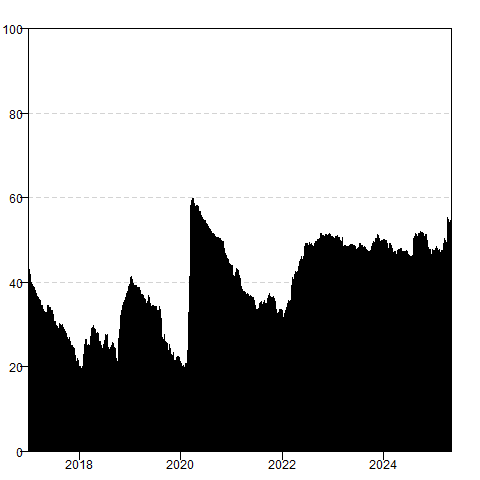

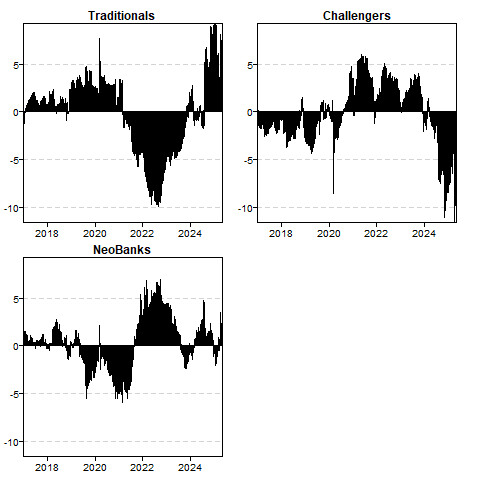

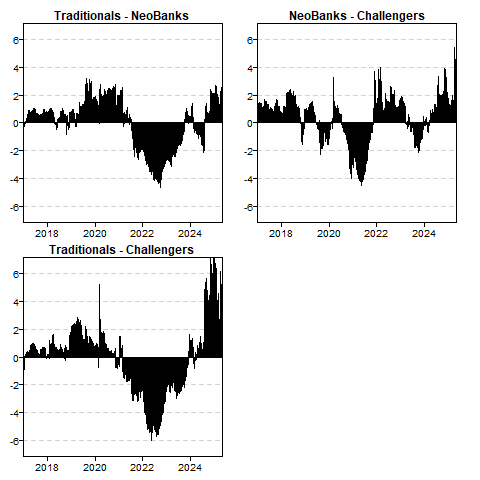

In [18]:
%%R -o dca_tvp_var_results

# This cell runs the more advanced TVP-VAR model.
# It uses the same 'returns_df' created in the Python cell.

if (nrow(returns_df) > 0) {
    library(ConnectednessApproach)
    library(zoo)

    data_zoo <- zoo(returns_df, order.by = as.Date(rownames(returns_df)))

    # --- Run the Dynamic Connectedness Analysis using TVP-VAR ---
    # The key changes are: model="TVP-VAR" and the VAR_config list.
    # The kappa parameters are "forgetting factors" that control how fast the parameters can change.
    # 0.99 is a very standard value.
    dca_tvp_var_results <- ConnectednessApproach(data_zoo,
                                       nlag = 2,
                                       nfore = 10,
                                       model = "TVP-VAR",
                                       VAR_config = list(TVPVAR = list(kappa1 = 0.99, kappa2 = 0.99, prior = "BayesPrior"))
                                       )

    # Print the resulting connectedness table
    print("--- TVP-VAR Average Connectedness Table ---")
    print(dca_tvp_var_results$TABLE)

    # --- Generate the plots for the TVP-VAR results ---
    print("--- Plotting TVP-VAR Dynamic Results ---")
    PlotTCI(dca_tvp_var_results)
    PlotNET(dca_tvp_var_results)
    PlotNPDC(dca_tvp_var_results)

} else {
    print("Input data is empty. Skipping TVP-VAR analysis.")
}

To ensure the robustness of our findings and to investigate the spillover dynamics with greater flexibility, we supplement our rolling-window analysis with a Time-Varying Parameter Vector Autoregression (TVP-VAR) model. This state-of-the-art technique relaxes the assumption of parameter stability inherent in fixed-window estimations, allowing the system's interconnectedness to evolve at every time step. The TVP-VAR is especially adept at identifying rapid shifts in market regimes that might be smoothed over by a rolling-window analysis. By comparing the results from both methodologies, we can draw more resilient conclusions about the nature of return spillovers among the banking sectors.